# Bayes Model

- In this notebook I will be running the data through a Bayes Classifier Model testing out different parameters of Bayes to see if we can get a model to predict if a submission came from the Shower Thoughts subreddit or the Today I Learned subreddit

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

In [2]:
df = pd.read_csv('./data/cleaned_data.csv')

In [3]:
df.head()

,title,subreddit,post_length,post_word_count
0,there were probably a lot of singers talented ...,1,91,17
1,sometimes i really miss college then i get out...,1,90,18
2,someone at some point gave the first blowjob i...,1,61,11
3,ab💿efg,1,6,1
4,the first person to find a cat must have been ...,1,54,11


In [4]:
#checking for nulls
df.isnull().sum()

title              2
subreddit          0
post_length        0
post_word_count    0
dtype: int64

In [5]:
#since there are two I am just going to drop them
df.dropna(inplace=True)

### Finding Baseline Score

In [6]:
df['subreddit'].value_counts(normalize=True).mul(100).round(2)

1    61.69
0    38.31
Name: subreddit, dtype: float64

We have a baseline accuracy score of about 62% if our model predicts a submission to be in the Shower thoughts subreddit since shower thoughts = 1 and today i learned = 0.

### Pre-processing and Modeling with Count Vectorizer

In [7]:
#set variables with target being subreddit and feature as title
X = df['title']

y = df['subreddit']

In [8]:
#train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10764,), (3589,), (10764,), (3589,))

In [10]:
#set up stop words to put in pipeline
#need to add the abbreviation for today i learned to stop words so we can drop it
extra_stop_words = ['til', 'today', 'learned', 'shower', 'thoughts']

#code help from https://stackoverflow.com/questions/24386489/
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

In [11]:
#set up pipeline for bayes model
pipe = Pipeline([('cvec', CountVectorizer(stop_words=stop_words)),
                 ('mnb',  MultinomialNB())])


In [12]:
#uncomment to see the different parameters we can use for this pipeline
#pipe.get_params()

In [13]:
#set up pipe parameters
pipe_params = {'cvec__max_features': [2000, 3000, 4000],
               'cvec__min_df': [2, 3],
               'cvec__max_df': [.9, .95],
               'cvec__ngram_range': [(1,1), (1,2)]}

In [14]:
grid = GridSearchCV(pipe,
                    param_grid = pipe_params,
                    cv=5)

In [15]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [16]:
print(grid.best_score_)

0.8337981756242263


In [17]:
grid.score(X_test, y_test)

0.8305934800780161

In [18]:
#get predictions
preds = grid.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

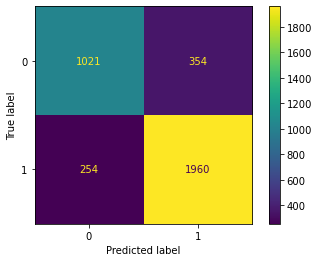

In [19]:
plot_confusion_matrix(grid, X_test, y_test);

In [20]:
#calculating specifity

spec = tn / (tn + fp)

print(f'Specifity score:', spec)

Specifity score: 0.7425454545454545


### Pre-processing and Modeling with Tfdif Vectorizer

In [21]:
#set up pipe with tvec
pipe_tvec = Pipeline([('tvec', TfidfVectorizer()),
                      ('mnb', MultinomialNB())
                     ])

In [22]:
#uncomment to see parameters we can use for this pipeline
#pipe_tvec.get_params()

In [23]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [24]:
tvec_grid = GridSearchCV(pipe_tvec,
                         param_grid=pipe_tvec_params,
                         cv=5)

In [25]:
tvec_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am',
                                                         'among', 'amongst',
                        

In [26]:
print(tvec_grid.best_score_)

0.8214427607712589


In [27]:
tvec_grid.score(X_test, y_test)

0.8244636388966285

In [28]:
#get predictions
tvec_preds = tvec_grid.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, tvec_preds).ravel()

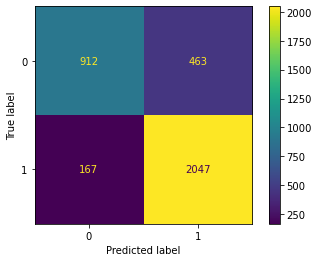

In [29]:
plot_confusion_matrix(tvec_grid, X_test, y_test);

In [30]:
#calculating specifity

spec = tn / (tn + fp)

print(f'Specifity score:', spec)

Specifity score: 0.6632727272727272
